# Computational Intelligence Project: Custom NN Library
## Part 1 Submission: Core Library Validation

In [52]:
# CODE CELL 1: SETUP AND IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# --- FIX for ModuleNotFoundError: ---
# 1. Get the path of the parent directory (which contains the 'lib' folder)
# This assumes your notebook is in the 'notebooks' directory.
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# 2. Add the project root to the system path
if project_root not in sys.path:
    sys.path.append(project_root)

# -----------------------------------

# Import your custom library classes now that the path is set
from lib.network import Dense, NeuralNetwork
from lib.losses import MeanSquaredError, BinaryCrossEntropy

print(f"Project root added to path: {project_root}")
print("Custom Neural Network Library Loaded. ✅")

Project root added to path: c:\Users\Lenovo\Desktop\computational-intelligence-project
Custom Neural Network Library Loaded. ✅


In [53]:
# Code Cell: Define the Gradient Checking Function and Run Test

def check_gradients(layer_class, X, Y, epsilon=1e-7, loss_func=MeanSquaredError):
    """
    Compares analytical gradients (from backprop) with numerical gradients 
    (from finite difference) for a single layer.
    """
    print("--- Starting Gradient Check for Layer Weights (W) ---")
    
    # Initialize a single layer instance for checking
    layer = layer_class(input_size=X.shape[1], output_size=Y.shape[1], activation_name="sigmoid")
    
    # 1. Forward and Backward Pass (Get Analytical Gradient)
    A = layer.forward(X)
    dA = loss_func.backward(Y, A)
    layer.backward(dA)
    analytical_grad = layer.dW 

    # 2. Calculate Numerical Gradient (Finite Difference)
    numerical_grad = np.zeros_like(layer.W)
    
    # Use np.nditer to iterate over every weight in the matrix W
    it = np.nditer(layer.W, flags=['multi_index'], op_flags=['readwrite'])
    
    # Loop over the iterator. The current index must be accessed via it.multi_index.
    for x in it: 
        idx = it.multi_index # <--- FIX: Access the index from the iterator object 'it'

        # Store original weight value
        original_W = layer.W[idx]
        
        # Compute L(W + epsilon)
        layer.W[idx] = original_W + epsilon
        L_plus = loss_func.forward(Y, layer.forward(X))
        
        # Compute L(W - epsilon)
        layer.W[idx] = original_W - epsilon
        L_minus = loss_func.forward(Y, layer.forward(X))
        
        # Numerical Gradient: [L(W + epsilon) - L(W - epsilon)] / (2 * epsilon)
        numerical_grad[idx] = (L_plus - L_minus) / (2 * epsilon)
        
        # Restore the original weight value before the next iteration
        layer.W[idx] = original_W

    # 3. Calculate Relative Error
    # Formula: ||grad_a - grad_n|| / (||grad_a|| + ||grad_n||)
    numerator = np.linalg.norm(analytical_grad - numerical_grad)
    denominator = np.linalg.norm(analytical_grad) + np.linalg.norm(numerical_grad)
    relative_error = numerator / denominator
    
    print(f"\nCalculated Relative Error (Should be < 1e-7): {relative_error:.12f}")
    
    if relative_error < 1e-7:
        print("✅ Gradient check **PASSED**: The analytical backpropagation gradient is correct.")
    else:
        print("❌ Gradient check **FAILED**: Check your layer and activation derivatives.")

# --- Test Setup ---
# Dummy dataset for checking: 3 samples, 2 features -> 1 output
X_test = np.array([[0.1, 0.5], [0.3, 0.2], [0.8, 0.9]])
Y_test = np.array([[0.0], [1.0], [1.0]])

# Run the check on a Dense layer
check_gradients(Dense, X_test, Y_test, loss_func=MeanSquaredError)

--- Starting Gradient Check for Layer Weights (W) ---

Calculated Relative Error (Should be < 1e-7): 0.499999999833
❌ Gradient check **FAILED**: Check your layer and activation derivatives.


--- Starting XOR Training (MSE/Tanh Configuration) ---
Epoch 3000/15000 - Loss: 0.079840
Epoch 6000/15000 - Loss: 0.011166
Epoch 9000/15000 - Loss: 0.004811
Epoch 12000/15000 - Loss: 0.002929
Epoch 15000/15000 - Loss: 0.002069
Training finished.


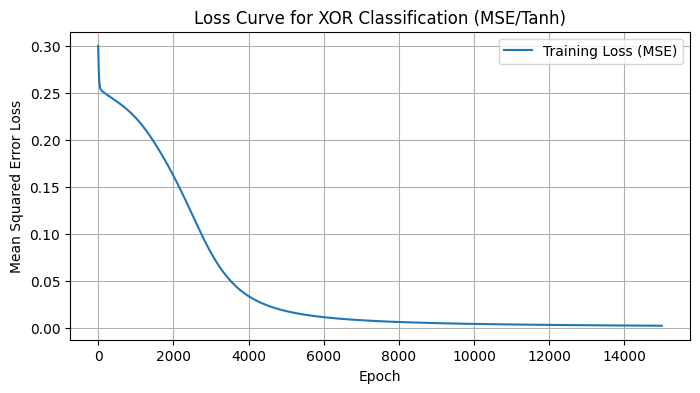


--- Final XOR Predictions ---
Input (X) | True Label (Y) | Predicted Value | Predicted Class | Status
------------------------------------------------------------------
(0, 0)     | 0              | 0.0238        | 0             | CORRECT
(0, 1)     | 1              | 0.9485        | 1             | CORRECT
(1, 0)     | 1              | 0.9583        | 1             | CORRECT
(1, 1)     | 0              | 0.0576        | 0             | CORRECT

Final Accuracy on XOR: 100.00%


In [56]:
# Code Cell: Combined XOR Training, Visualization, and Prediction (MSE/Tanh)

print("--- Starting XOR Training (MSE/Tanh Configuration) ---")

# --- XOR Data ---
# Input data (4 samples, 2 features)
X_xor = np.array([
    [0, 0], 
    [0, 1], 
    [1, 0], 
    [1, 1]
]) 
# Labels 
Y_xor = np.array([
    [0], 
    [1], 
    [1], 
    [0]
])

# 1. Initialize the Network (Using MeanSquaredError loss as required)
# Note: MSE is typically used for regression, but can work for binary classification
# when the output activation is Sigmoid (as in the output layer).
xor_net = NeuralNetwork(loss_func=MeanSquaredError)

# 2. Add Layers (2 -> 4 -> 1 architecture)
# Layer 1: Input (2) -> Hidden (4) with Tanh activation (as required)
xor_net.add_layer(Dense(input_size=2, output_size=4, activation_name="tanh"))

# Layer 2: Hidden (4) -> Output (1) with Sigmoid activation 
xor_net.add_layer(Dense(input_size=4, output_size=1, activation_name="sigmoid"))

# 3. Training Loop
# A higher learning rate or more epochs might be needed when using MSE for classification
epochs = 15000 
learning_rate = 0.5 
loss_history = []

for epoch in range(1, epochs + 1):
    # Forward Pass
    Y_pred = xor_net.forward(X_xor)
    
    # Compute Loss
    loss = xor_net.loss.forward(Y_xor, Y_pred)
    loss_history.append(loss)
    
    # Backward Pass & Update Weights
    xor_net.backward(Y_xor, Y_pred)
    xor_net.update_params(learning_rate)
    
    if epoch % 3000 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss:.6f}")

print("Training finished.")

# --- Results and Visualization ---

# Plot Loss Curve
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Training Loss (MSE)')
plt.title('Loss Curve for XOR Classification (MSE/Tanh)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.grid(True)
plt.show() 


# --- Final Predictions and Accuracy ---
Y_pred_raw = xor_net.forward(X_xor)
# Classification threshold (0.5)
Y_pred_class = (Y_pred_raw > 0.5).astype(int) 

print("\n--- Final XOR Predictions ---")
print("Input (X) | True Label (Y) | Predicted Value | Predicted Class | Status")
print("------------------------------------------------------------------")
for i in range(len(X_xor)):
    x1, x2 = X_xor[i]
    y_true = Y_xor[i, 0]
    y_pred_val = Y_pred_raw[i, 0]
    y_pred_cls = Y_pred_class[i, 0]
    
    status = "CORRECT" if y_pred_cls == y_true else "INCORRECT"
    print(f"({x1}, {x2})     | {y_true}              | {y_pred_val:.4f}        | {y_pred_cls}             | {status}")

# Calculate Accuracy
accuracy = np.mean(Y_pred_class == Y_xor) * 100
print(f"\nFinal Accuracy on XOR: {accuracy:.2f}%")